### Тема: обработка временных рядов рекуррентными нейронными сетями (LSTM, GRU)
Задание:

1. взять набор данных с временным рядом

2. Обучить нейронную сеть с блоками LSTM или GRU (подобрать наиболее подходящие)

    2.1 Подобрать размер скользящего окна

    2.2 Подобрать оптималные параметры нейронной сети

    2.3 Ввиду ресурсоемкости процесса обучения, целесообразно сохранить обученную модель

3. Построить график с наложением исходной цены и спрогнозированной по всей обучаующей и тестовой выборок

4. Спрогнозировать цену на следующий временной шаг

In [2]:
from zipfile import ZipFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense

In [3]:
df = pd.read_csv('features_target.csv')
df['Unnamed: 0'] = pd.to_datetime(df['Unnamed: 0'])
df.rename(columns = {'Unnamed: 0':'Date'}, inplace = True) 
df.set_index('Date', inplace = True)
price = df['SP500'].to_numpy()
df.head()

,SP500,SP500 Log Returns,SP500 30 Day Volatility,SPX Put Call Ratio,SPX Put Volume,SPX Call Volume,Total SPX Options Volume,VIX,DJIA,NASDAQ,...,NASDAQ_log_returns,RUSSELL_log_returns,MSCI_World_log_returns,USD_Index_log_returns,Gold_log_returns,Oil_log_returns,SP500_put_log_change,SP500_call_log_change,SP500_total_opts_log_change,Consumer_Sentiment_log_change
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-08,1070.25,0.009369,28.510976,1.12,280436.0,251021.0,531457.0,25.71,10138.99,2175.40,...,0.007350,0.013978,0.012148,0.000000,-0.002338,0.018862,-0.076998,-0.278034,-0.176999,0.0
2010-07-09,1077.96,0.007178,28.462814,1.20,376805.0,315132.0,691937.0,24.98,10198.03,2196.45,...,0.009630,0.014660,0.006065,0.001550,0.011389,0.008183,0.295382,0.227455,0.263873,0.0
2010-07-12,1078.75,0.000733,28.041079,1.49,421390.0,283127.0,704517.0,24.43,10216.27,2198.36,...,0.000869,-0.012502,0.000000,0.002974,-0.009217,-0.015231,0.111831,-0.107096,0.018018,0.0
2010-07-13,1095.34,0.015262,28.157439,1.25,652349.0,519892.0,1172241.0,24.56,10363.02,2242.03,...,0.019670,0.033552,0.015906,-0.006673,0.012271,0.029327,0.437021,0.607726,0.509160,0.0
2010-07-14,1095.17,-0.000155,28.338036,1.01,475499.0,469171.0,944670.0,24.89,10366.72,2249.84,...,0.003477,-0.004147,0.003690,-0.002514,-0.005371,-0.001816,-0.316215,-0.102654,-0.215837,0.0


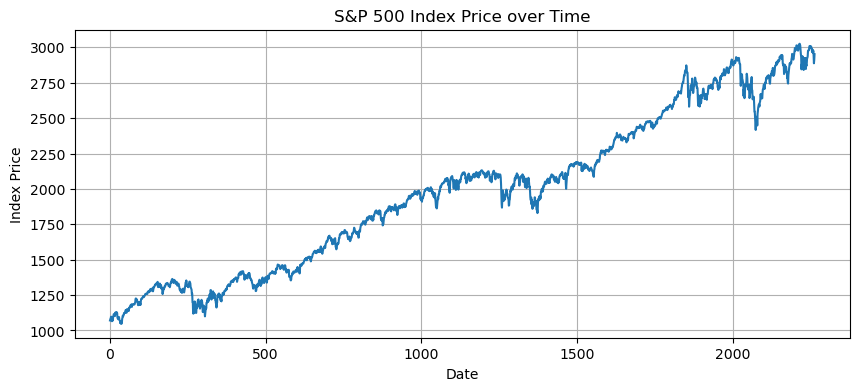

In [4]:
plt.figure(figsize=(10,4))
plt.grid()
plt.plot(price)
plt.xlabel('Date')
plt.ylabel('Index Price')
plt.title('S&P 500 Index Price over Time')
plt.show()

In [5]:
def makeTimeSeries( data, windowSize = 100 ):
    slideWindows = []
    for start in range( len(data) - windowSize + 1 ):
        slideWindows.append( data[start:start + windowSize] )
    return np.array(slideWindows)


useWindowSize = 80
timeSeries = makeTimeSeries( price, windowSize = useWindowSize + 1 )

mi = np.min(timeSeries)
ma = np.max(timeSeries)

timeSeries_n = (timeSeries - mi) / (ma - mi)

timeSeries.shape

(2184, 81)

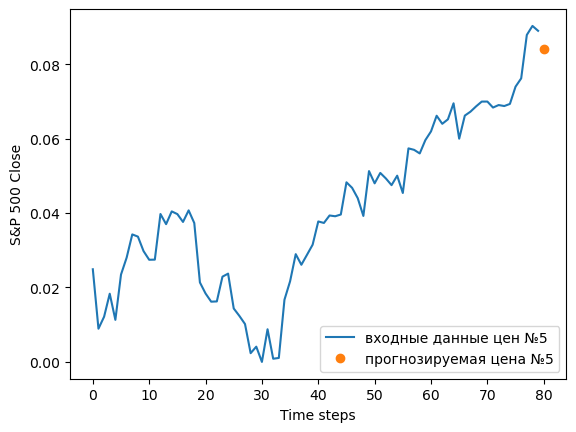

In [6]:
x = timeSeries_n[:,:-1]
y = timeSeries_n[:,-1]

sw = 5
plt.plot( np.arange(useWindowSize), x[sw], label = f"входные данные цен №{sw}")
plt.plot( useWindowSize, y[sw], 'o', label = f"прогнозируемая цена №{sw}" )
plt.xlabel("Time steps")
plt.ylabel("S&P 500 Close")
plt.legend( loc = "lower right" )
plt.show()

In [7]:
xtrain, xtest, ytrain, ytest = train_test_split( x,y, train_size = 0.8, shuffle = False )

xtrainr = xtrain.reshape(-1, xtrain.shape[1], 1)
xtestr = xtest.reshape(-1, xtest.shape[1], 1)
ytrainr = ytrain.reshape(-1,1)
ytestr = ytest.reshape(-1,1)


rnn = Sequential([
    LSTM( units = 64, return_sequences = True ),
    LSTM( units = 64, return_sequences = False ),
    Dense( units = 1, activation = "linear")
])

rnn.compile( loss = "mse", optimizer = "adam" )

hist = rnn.fit( xtrainr, ytrainr, epochs = 50, batch_size = 100 )

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0576
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0029
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 7.9506e-04
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 2.5782e-04
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 2.5601e-04
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 2.4204e-04
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 2.5614e-04
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 2.3796e-04
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 2.4563e-04
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 2.4429e-04
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 2.4536e-04
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 2.6945e-04
Epoch 13/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 2.4495e-04
Epoch 14/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 2.4310e-04
Epoch 15/50
18/18 ━━━━━

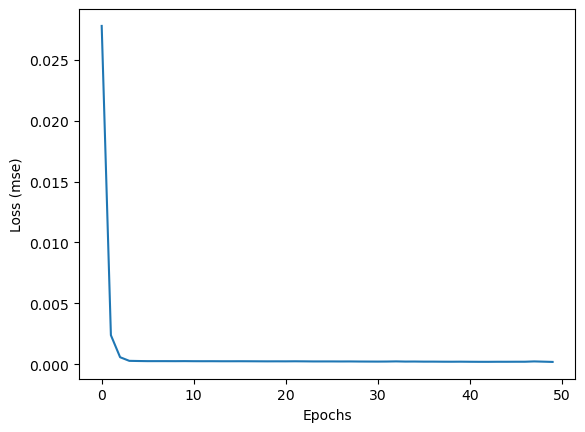

In [8]:
plt.plot( hist.history["loss"] )
plt.xlabel("Epochs")
plt.ylabel(f"Loss ({rnn.loss})")
plt.show()

In [9]:
rnn.evaluate( xtestr, ytestr )

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.5261e-04 


0.0005882600671611726

In [10]:
yPred = rnn.predict( xtest )

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [11]:
yPred.shape

(437, 1)

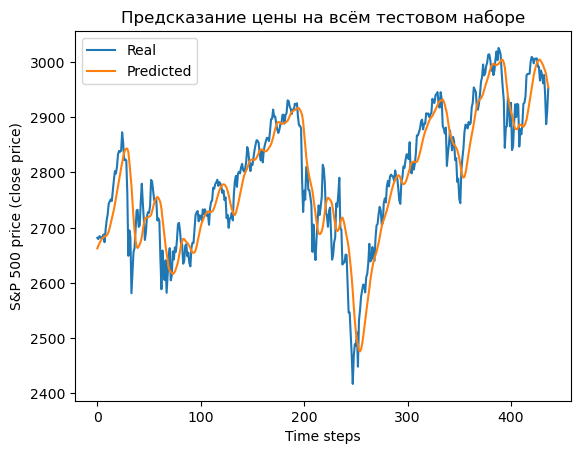

In [12]:
plt.plot( ytest * (ma - mi) + mi, label = "Real" )
plt.plot( yPred.reshape(-1) * (ma - mi) + mi, label = "Predicted" )
plt.xlabel("Time steps")
plt.ylabel("S&P 500 price (close price)")
plt.title("Предсказание цены на всём тестовом наборе")
plt.legend()
plt.show()

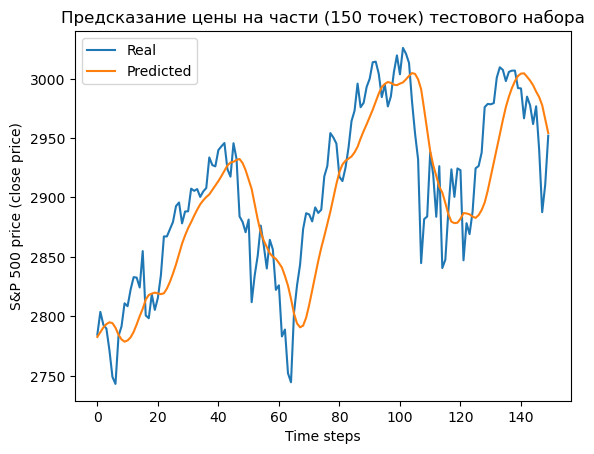

In [13]:
lastTicksCount = 150
plt.plot( ytest[-lastTicksCount:] * (ma - mi) + mi, label = "Real" )
plt.plot( yPred.reshape(-1)[-lastTicksCount:] * (ma - mi) + mi, label = "Predicted" )
plt.xlabel("Time steps")
plt.ylabel("S&P 500 price (close price)")
plt.title(f"Предсказание цены на части ({lastTicksCount} точек) тестового набора")
plt.legend()
plt.show()

In [14]:
predictWindow = (price[-useWindowSize:] - mi) / (ma - mi) # одновременно нормируем

# для подачи на вход модели нужно этот ряд привести к форме (моменты времни = 1, свойства = 100, каналы = 1)
predictWindow_r = predictWindow.reshape(1,-1,1)
predictWindow_r.shape

extrapolated = rnn(predictWindow_r)
extrapolated

print(f"Предсказание цены: {extrapolated[0][0] * (ma - mi) + mi}")

Предсказание цены: 2946.06689453125


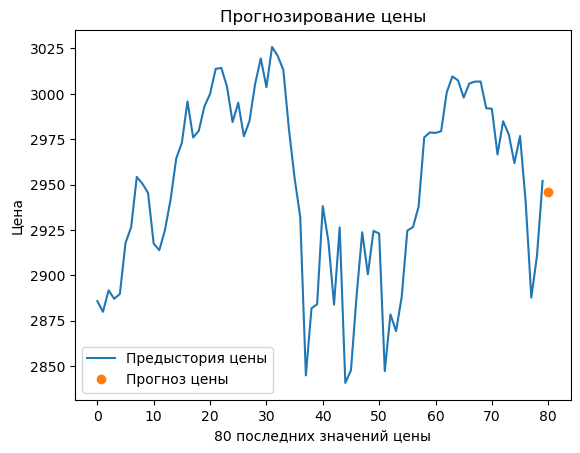

In [15]:
plt.plot( np.arange(useWindowSize), predictWindow * (ma - mi) + mi, label = "Предыстория цены" )
plt.plot( useWindowSize, extrapolated[0][0] * (ma - mi) + mi, 'o', label = "Прогноз цены" )
plt.title("Прогнозирование цены")
plt.ylabel("Цена")
plt.xlabel(f"{useWindowSize} последних значений цены")
plt.legend()
plt.show()